In [1]:
import numpy as np
import tensorflow as tf
tf.enable_eager_execution()
import gym

import os
import sys
import PIL.Image as image
import json
import time
from collections import deque
import matplotlib.pyplot as plt

In [3]:
env=gym.make('SpaceInvaders-v0')

In [2]:
# hyperparameters
batch_size = 2 # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = True
state_size=[84,84,4] # 4 continous frames are feeded so that nn gets a sense of motion
action_size=env.action_space.n # total actions available
possible_action=np.identity(4, dtype=int).tolist() # one_hot conversion of actions

In [4]:
# for testing gym
state2=env.reset()
for a in range(2):
    env.reset()
    for x in range(1000):
        env.render()
        action=env.action_space.sample()
        o, r, d, i= env.step(action)
env.close()

In [5]:
#operations for space invaders

# 0 no-op
# 1 fire
# 2 right
# 3 left
# 4 right + fire
# 5 left + fire

# we will use only the first 4 operations i.e. no op, fire, left and right

In [6]:
def preprocess(I):
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I=image.fromarray(I).resize((84,84))
    I=np.array(I)/255 #normalizing inputs
    return I

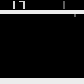

In [16]:
image.fromarray(np.uint8(preprocess(o)*255)) # visualising out preprocessed image

In [8]:
stack_size = 4 # We stack 4 frames

# Initialize deque with zero-images one array for each image
stacked_frames  =  deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4) 

def stack_frames(stacked_frames, state, done = False):
    # Preprocess frame
    frame = preprocess(state)
    
    if done:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
        
        # Because we're in a new episode, copy the same frame 4x
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        
        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=2)

    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)

        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=2) 
    
    return stacked_state, stacked_frames


In [9]:
def discount_rewards(r):
    # take 1D float array of rewards and compute discounted reward 
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    
    # normalising rewards
    mean = np.mean(discounted_r)
    std = np.std(discounted_r)
    discounted_r = (discounted_r - mean) / (std)
    return discounted_r

In [10]:
class policy_forward(tf.keras.Model):
    def __init__(self):
        super(policy_forward, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(16, (8, 8), strides=(4, 4), padding='valid')
        self.conv2 = tf.keras.layers.Conv2D(32, (4, 4), strides=(2, 2), padding='valid')
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(256)
        self.fc2 = tf.keras.layers.Dense(action_size)

    def call(self, x, training=True):
        x = tf.nn.leaky_relu(self.conv1(x))
        x = tf.nn.leaky_relu(self.conv2(x))
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        prob = tf.nn.softmax(x)
        return x, prob

In [11]:
pg_network=policy_forward()
pg_network.call = tf.contrib.eager.defun(pg_network.call) # gives better performance/call for eager execution

In [12]:
def policy_loss(predicted, actions, discounted_rewards):
    entropy_loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=predicted, labels=actions) #softmax entropy
    loss = tf.reduce_mean(entropy_loss*discounted_rewards) # rewards*loss (main step in pg gradient update)
    return loss

In [13]:
optimizer = tf.train.AdamOptimizer(learning_rate)

In [14]:
checkpoint_dir = 'policy_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer = optimizer, pg = pg)

In [15]:
epoch = 0
episode = 0
global_rewards = []
state = env.reset()
# Initialize lists: states, actions, rewards_of_episode, rewards_of_batch, discounted_rewards
states, actions,action_logits_of_batch, rewards_of_episode, rewards_of_batch, discounted_rewards = [], [], [], [], [], []
#initialize our stacked frames
stacked_state, stacked_frames = stack_frames(stacked_frames, state, True)
while True:
    if render: env.render()
    action_logits, action_prob = pg(tf.convert_to_tensor(stacked_state.reshape(1, *state_size), dtype=tf.float32))
    action=np.random.choice(4, p=np.array(action_prob).ravel()) # take action based on random chance given our prob's
    
    action_onehot=possible_action[action] # get one hot representation for our action
    observation, reward, done, info = env.step(action)
    if done:
        episode += 1

        rewards_of_batch.append(rewards_of_episode) # used for calculating gradients
        discounted= discount_rewards(np.array(rewards_of_episode)) # calculate the discounted_rewards
        discounted_rewards.append(discounted) 
            
        if(episode%batch_size==0):
            epoch+=1
            
            # converting actions and rewards to tensors
            stacked_actions = tf.stack(actions)
            stacked_discounted_rewards =tf.cast(tf.concat(discounted_rewards, axis=0), tf.float32)
            
            with tf.GradientTape() as pg_gradient_tape:
                stacked_logits = pg(tf.convert_to_tensor(np.array(states), dtype=tf.float32))
                loss = policy_loss(stacked_logits[0], stacked_actions, stacked_discounted_rewards)
                
            gradients = pg_gradient_tape.gradient(loss, pg.variables) # calculating gradients
            optimizer.apply_gradients(zip(gradients, pg.variables)) # 1 update step
                
                
            total_rewards = np.sum(np.concatenate(rewards_of_batch))
            mean_reward = np.divide(total_rewards, episode)
            global_rewards.append(total_rewards)
            print("==========================================")
            print("Epoch: ", epoch)
            print("-----------")
            print("Total reward: {}".format(total_rewards))
            print("Mean Reward of that batch {}".format(mean_reward))
            print("Max Reward till now {}".format(np.amax(global_rewards)))
            episode=0
            states, actions,action_logits_of_batch, rewards_of_batch, discounted_rewards = [], [], [], [], []      
        if(epoch % 15 == 0):
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        rewards_of_episode = []
        state = env.reset()
        stacked_state, stacked_frames = stack_frames(stacked_frames, state, True) 
                
    else:
        state=observation
        states.append(stacked_state)
        actions.append(action_onehot)
        action_logits_of_batch.append(action_logits)
        rewards_of_episode.append(reward)
        stacked_state, stacked_frames = stack_frames(stacked_frames, state)

Epoch:  1
-----------
Total reward: -20.0
Mean Reward of that batch -20.0
Epoch:  2
-----------
Total reward: -19.0
Mean Reward of that batch -19.0


KeyboardInterrupt: 